<!-- # Princeton Web Scraping Task -->

- **Author:** Cameron Raymond
- **Affliation:** University of Oxford, Oxford Internet Institute
- **Program:** MSc, Social Data Science
- **Email:** [cameron.raymond@hey.com](mailto:cameron.raymond@hey.com)
- **Github Repo:** [cameron-raymond/princeton-scraping-task](https://github.com/cameron-raymond/princeton-scraping-task)
- **Purpose:** Demonstrate an understanding of the web-scraping and data wrangling skills needed to perform research at Princeton's Stigma and Social Perception Lab.

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np
# Common webscraping libaries
from bs4 import BeautifulSoup as bs
import requests

# Get list of universities

I noticed that when you clicked the "load more" button on the original webpage, it made a call to a public API. Click [here](https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=1&schoolType=national-universities) to see the JSON structure (relevant data is under the `data/items` field). This returned a lot of relevant data in a JSON format. Webscrapers are notoriously brittle (ie they often break if the webpage changes) so getting as much data from the source is preferable.

In [2]:
initial_url = f"https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=1&schoolType=national-universities"

def get_page_data(url):
    """
        Takes in the URL to the us news api. Returns the page data and url to get the next page of data.
    """
    json = requests.get(url,headers = {'User-Agent': 'Mozilla/5.0'})
    page_data = json.json()['data']
    next_link = page_data["next_link"]
    return page_data['items'],next_link

def parse_item(university):
    """
        Each university is represented by a dictionary, this function parses out the relevant features
    """
    name = university['institution']['displayName']
    ranking = university['institution']['rankingDisplayRank']
    page_url = f"{university['institution']['urlName']}-{university['institution']['primaryKey']}"
    return {"Name": name,"Ranking":ranking,"info_page": page_url}

# Collect the list of universities that are ranked by US News
records = []
url,next_link = initial_url, initial_url
while next_link:
#     print(url)
#     Get the raw JSON data
    page_data, next_link = get_page_data(url)
#     parse out the relevant fields (name, ranking and link to the details page)
    record_subset = map(parse_item,page_data)
    records += record_subset
#     set the url to fetch from to be the next_link given (will be "None" if we're at the end)
    url = next_link

uni_df = pd.DataFrame.from_records(records)
uni_df.head()

,Name,Ranking,info_page
0,Princeton University,#1,princeton-university-2627
1,Harvard University,#2,harvard-university-2155
2,Columbia University,#3,columbia-university-2707
3,Massachusetts Institute of Technology,#4,massachusetts-institute-of-technology-2178
4,Yale University,#4,yale-university-1426


# Parse information from website profiles

Since the API doesn't have a publically available endpoint that returns the website profile data in a JSON format I'll scrape the html page and parse info from that directly.

In [3]:
def parse_info_page(info_page):
#     The info page parameter gives the url suffix    
    url = f"https://www.usnews.com/best-colleges/{info_page}"
    r = requests.get(url,headers = {'User-Agent': 'Mozilla/5.0'})
#     Beautifulsoup provides functionality to manipulate HTML data.
    soup = bs(r.text)
    overview = get_overview(soup)
    general_information = get_general_information(soup)
#     Merge the two sets of information into one dictionary
    page_info = overview | general_information
    return pd.Series(page_info)

def get_overview(soup):
#     mb5 is a big div with the overview text, but it also contains a lot of junk/random html components
    overview = soup.findAll("div",{"class":"mb5"})[5]
#     Find all the text tags (drop the last one as it is an advertisement)
    overview = overview.findAll("p")[:-1]
#     Use the join command to put it into one string. Use the lambda function to get rid of the html tags and
#     only keep the text within the <p> </p> tags.
    overview = " ".join(map(lambda x : x.text,overview))
    return {"Overview": overview}

def get_general_information(soup):
    info_dict = {}
#     The general information section is a div with the class below. It contains multiple other divs which
#     represent the various rows. First we find the container div, and then we break that up into a list of the
#     remaining rows
    general_information = soup.find("div",{"class":"Cell-sc-1abjmm4-0 dsivYq"}).findAll("div")
#     We leave out the last element (the school website) as it has a different structure
    general_information, website = general_information[:-1],general_information[-1]
    for div in general_information:
#         Each row has two <p> tags, the first represents the type of info, 
#         and the second represents the value
        key, value = div.findAll("p")
        info_dict[key.text] = value.text
#     The website URL is the only anchor tag in the general information div
    info_dict["School Website"] = website.find("a")["href"]
    return info_dict

In [4]:
# Now that we've written the functions that parse a single webpage, we go through each row in our original
# dataframe, take the "info_page" column (which indicates the url that the info page can be found at)
# and use the functions from the preceding cell to parse out that relevant info and add it to the dataframe
uni_df[["Overview",
        "School Type",
        "Year Founded",
        "Religious Affiliation",
        "Academic Calendar",
        "Setting",
        "2019 Endowment",
        "School Website"]] = uni_df["info_page"].apply(parse_info_page)
# Drop the info_page parameter as it wasn't requested
uni_df = uni_df.drop("info_page",axis=1)
uni_df.index.name = "Index"
uni_df.head()

,Name,Ranking,Overview,School Type,Year Founded,Religious Affiliation,Academic Calendar,Setting,2019 Endowment,School Website
Index,,,,,,,,,,
0,Princeton University,#1,Princeton University is a private institution ...,"Private, Coed",1746,None,Semester,Suburban,$25.6 billion +,http://www.princeton.edu
1,Harvard University,#2,Harvard University is a private institution th...,"Private, Coed",1636,None,Semester,Urban,$40.9 billion +,http://www.harvard.edu/
2,Columbia University,#3,Columbia University is a private institution t...,"Private, Coed",1754,None,Semester,Urban,$11.0 billion,http://www.columbia.edu
3,Massachusetts Institute of Technology,#4,Massachusetts Institute of Technology is a pri...,"Private, Coed",1861,None,4-1-4,Urban,$17.4 billion +,http://web.mit.edu/
4,Yale University,#4,Yale University is a private institution that ...,"Private, Coed",1701,None,Semester,City,$30.3 billion,http://www.yale.edu/


It is important to check if any rows have slipped through the cracks when rangling, or if there is an error in the code's logic.

In [5]:
# Check to see if there are any rows with missing data
assert len(uni_df[uni_df.isnull().any(axis=1)]) == 0, "Empty!"
print("All rows have data!")
# I picked a random university from the website and checked to make sure that it had the correct ranking in my data
ball_state = uni_df[uni_df["Name"] == "Ball State University"]
assert (ball_state["Ranking"] == "#284").all(), "Wrong ranking for Ball State University"
print("Correct ranking for Ball State University!")

All rows have data!
Correct ranking for Ball State University!


In [6]:
# Write the data to CSV.
uni_df.to_csv("usnews-college_info.csv")

# Additional parsing

This wasn't specified, but numeric fields like `ranking` and `endowment` need to be parsed as numbers. This poses some problems. First, the lower ranked universities are given by a range rather than a specific ranking (i.e. \#289-389). I'll use the upper bound of the ranking in this case. Second, the endowment column doesn't use a common unit (i.e millions, billions, etc.). This will require some logic to handle. After doing so, however, the data will be easier to visualize and work with in regression frameworks. 

In [38]:
uni_df = pd.read_csv('usnews-college_info.csv',index_col=0)

In [39]:
# This takes the `ranking` column and first removes the first digit (a # symbol) with .str[1:]
# then it splits that string into a list delineaed by the hyphen ('289-389' -> ['289','389'])
# and takes the first element from that list (.str[0]). Then I convert it to an integer.
uni_df['Ranking'] = uni_df['Ranking'].str[1:].str.split('-').str[0].astype(int)

In [79]:
multipliers = {
    'million': 1000000,
    'billion': 1000000000
}

def parse_endowment(end_str):
    # If the argument isn't a string return what it was
    if type(end_str) is not str:
        return end_str
    split = end_str.split()
    # If we split the endowment string and it is a list with only one element, then that means the
    # endowment wasn't reported, so return NaN
    if len(split) < 2:
        return np.nan
    try:
        # Third element is normally a '+' symbol, so we'll take the first two elements
        number,mult = split[:2]
        # Convert the number to a number type (1st symbol is dollar sign so remove that)
        number = float(number[1:]) 
        mult = multipliers[mult.lower()]
        return number * mult
    except:
        # If for whatever reason the above code fails to run notify and return None
        # I use None rather than NaN so that problematic rows can be isolated and inspected
        print("Parsing failed")
        return None
    
for x in ['$124.9 million +',np.nan,'NaN','nan','N/A','$40.9 billion +']:
    print(f"\"{x}\" gets parsed as {parse_endowment(x)}")

"$124.9 million +" gets parsed as 124900000.0
"nan" gets parsed as nan
"NaN" gets parsed as nan
"nan" gets parsed as nan
"N/A" gets parsed as nan
"$40.9 billion +" gets parsed as 40900000000.0


In [51]:
# Apply the above function to our dataframe
uni_df['2019 Endowment'] = uni_df['2019 Endowment'].apply(parse_endowment)

In [65]:
# Write the numeric data to CSV.
uni_df.to_csv("usnews-college_info-numeric.csv")

Now that the relevant numeric columns are parsed as such it is easy to do some basic visualizations.

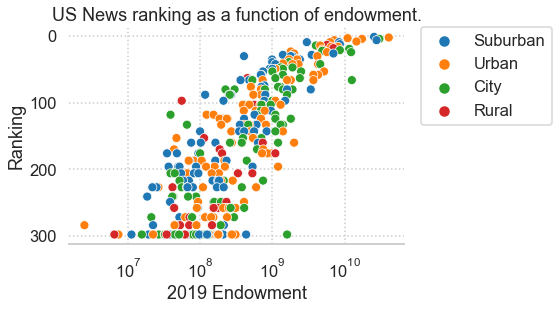

In [73]:
# Common graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("whitegrid",{'axes.spines.left' : False,
                           'axes.spines.right': False,
                           'axes.spines.top': False,
                           'grid.linestyle': ':'})
sns.set_context("talk")

g = sns.scatterplot(data=uni_df,x='2019 Endowment',y='Ranking',hue="Setting")
g.invert_yaxis()
g.set(xscale='log',title="US News ranking as a function of endowment.")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
None